In [69]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go


In [70]:
def get_image(image_path):
    return cv2.imread(image_path)

In [71]:
image = get_image('./Dataset/game1/Clip1/0000.jpg')

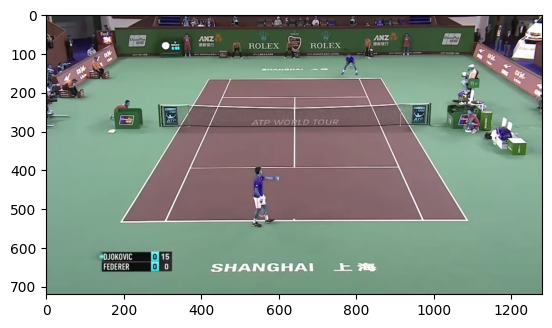

In [72]:
plt.imshow(image)

In [86]:
# Mouse callback function to collect points
points=[]
cv2.imshow('Select Points', image)
def get_points(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        print("Point selected: ({}, {})".format(x, y))

# Set the mouse callback
cv2.setMouseCallback('Select Points', get_points)

# Wait for the user to select points
cv2.waitKey(0)

# Close the image window
cv2.destroyAllWindows()

# Print the selected points
print("Selected Points:", points)

Point selected: (421, 167)
Point selected: (862, 164)
Point selected: (1091, 531)
Point selected: (199, 533)
Point selected: (291, 228)
Point selected: (994, 230)
Point selected: (762, 307)
Selected Points: [(421, 167), (862, 164), (1091, 531), (199, 533), (291, 228), (994, 230), (762, 307)]


In [87]:
# top left corner, top right corner, bottom right corner, bottom left corner, pole left, pole right
points=[(420, 165), (860, 165), (1090, 530), (200, 530), (291, 230), (992, 230)]
#plot points on frame
for point in points:
    cv2.circle(image, point, 5, (0, 0, 255), -1)
cv2.imshow('points',image)
cv2.waitKey(0)

# Close the image window
cv2.destroyAllWindows()



In [88]:
#true coords
# top left corner, top right corner, bottom right corner, bottom left corner, pole left, pole right
true_coords = [(0,23.77, 0), (10.97,23.77,  0), (10.97,0, 0),(0,0,0), (-0.91, 5.485,1.07), (11.42,5.485,1.07)]

In [89]:
A = []
for i in range(6):
    X, Y, Z = true_coords[i]
    u, v = points[i]
    A.append([X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u])
    A.append([0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z, -v])

In [90]:
A = np.array(A)


In [95]:
image.shape

(720, 1280, 3)

In [96]:
# svd of A
U, S, V = np.linalg.svd(A)

In [97]:
V.shape

(12, 12)

In [98]:
# get last column of V
p = V[-1, :]

In [99]:
p.shape

(12,)

In [100]:
# reshape to 
M = np.reshape(p, (3, 4))

In [101]:
M

array([[-1.33991539e-01, -4.51309383e-02, -2.14865150e-01,
        -3.30311726e-01],
       [-7.58370101e-19,  1.36356071e-02,  2.41561812e-01,
        -8.75326075e-01],
       [-3.41790523e-17, -7.10599098e-05, -2.94837532e-04,
        -1.65155863e-03]])

In [102]:
a1 = M[0, :3]
a2 = M[1, :3]
a3 = M[2, :3]
b1 = M[0, 3]
b2 = M[1, 3]
b3 = M[2, 3]

In [103]:
rho = 1 / np.linalg.norm(a3)
cx = rho**2 * np.dot(a1, a3)
cy = rho**2 * np.dot(a2, a3)
cos_theta = -np.dot(np.cross(a1, a3), np.cross(a2, a3)) / (np.linalg.norm(np.cross(a1, a3)) * np.linalg.norm(np.cross(a2, a3)))
sin_tetha = np.sqrt(1 - cos_theta**2)
alpha = rho**2 * np.linalg.norm(np.cross(a1, a3)) * sin_tetha
beta = rho**2 * np.linalg.norm(np.cross(a2, a3)) * sin_tetha

In [104]:
cy

-784.8604998864747

In [105]:
K = np.array([[alpha, -alpha* (cos_theta/sin_tetha), cx], [0, beta/ sin_tetha, cy], [0, 0, 1]])
#K = np.array([[alpha, 0, cx], [0, alpha, cy], [0, 0, 1]])

In [106]:
K

array([[ 441.80821527,  -21.33107103,  723.6167164 ],
       [   0.        ,  142.91433308, -784.86049989],
       [   0.        ,    0.        ,    1.        ]])

In [107]:
# get R and T
r1 = (np.cross(a2, a3) / np.linalg.norm(np.cross(a2, a3)))
r3= rho * a3
r2 = np.cross(r3, r1)

In [108]:
b = np.array([b1, b2, b3])
t = rho* np.linalg.inv(K).dot(b)

In [109]:
# use K R and t to project the points in 3d and show with matplotlib
points_2d = np.array(points)
# add 1 to the points
points_2d = np.hstack((points_2d, np.ones((6, 1))))
points_2d


array([[4.20e+02, 1.65e+02, 1.00e+00],
       [8.60e+02, 1.65e+02, 1.00e+00],
       [1.09e+03, 5.30e+02, 1.00e+00],
       [2.00e+02, 5.30e+02, 1.00e+00],
       [2.91e+02, 2.30e+02, 1.00e+00],
       [9.92e+02, 2.30e+02, 1.00e+00]])

In [110]:
R = np.array([r1, r2, r3])

In [111]:
t = t.reshape(3, 1)
t

array([[  4.03503228],
       [-50.10191201],
       [ -5.44565856]])

In [112]:
points_normalized = np.linalg.inv(K) @ points_2d.T
points_3d = (np.linalg.inv(R) @ (points_normalized - t)).T


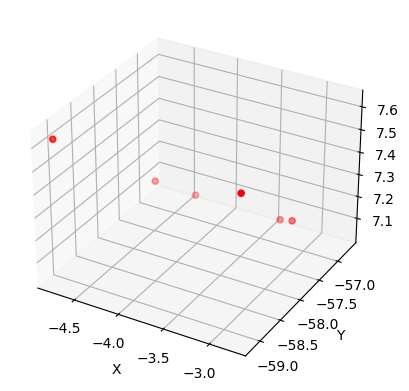

In [113]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='r', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [114]:
import plotly.graph_objects as go
x = points_3d[:, 0]
y = points_3d[:, 1]
z = points_3d[:, 2]

# Create Plotly figure
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5))])

# Set axes labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

# Show plot
fig.show()